In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm
import pandas as pd
import copy

In [2]:
def P_0_matrix(x):
    P_0_matrix=np.array([[1-x,x,0,0,0],
                   [1-x,0,x,0,0],
                   [1-x,0,0,x,0],
                   [1-x,0,0,0,x],
                   [1-x,0,0,0,x]])  
    return P_0_matrix

In [3]:
P_1_matrix=np.array([[1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0],
                   [1,0,0,0,0]])
P_1_matrix

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [4]:
def reward_matrix(x):
    reward_matrix=[[x**1,0],[x**2,0],[x**3,0],[x**4,0],[x**5,0]]
    return reward_matrix

In [5]:
action_space=[0,1]
state_space=[0,1,2,3,4]
N=5
M=1
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [6]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [7]:
Q_values=[]
for i in range(0,N):
  Q_values.append(reward_matrix((i+1)/10.0))
  
Q_values

[[[0.1, 0],
  [0.010000000000000002, 0],
  [0.0010000000000000002, 0],
  [0.00010000000000000002, 0],
  [1.0000000000000003e-05, 0]],
 [[0.2, 0],
  [0.04000000000000001, 0],
  [0.008000000000000002, 0],
  [0.0016000000000000003, 0],
  [0.0003200000000000001, 0]],
 [[0.3, 0],
  [0.09, 0],
  [0.026999999999999996, 0],
  [0.0081, 0],
  [0.0024299999999999994, 0]],
 [[0.4, 0],
  [0.16000000000000003, 0],
  [0.06400000000000002, 0],
  [0.025600000000000005, 0],
  [0.010240000000000003, 0]],
 [[0.5, 0], [0.25, 0], [0.125, 0], [0.0625, 0], [0.03125, 0]]]

In [8]:
Q_values_whittle=copy.deepcopy(Q_values)

In [9]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
  if action==1:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/10)
    return Q_values

  else:
    Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/10)
    return Q_values




In [10]:
def act(Q_values,epsilon,state,arm_index):
  decision=np.random.binomial(n=1,p=epsilon,size=1)
  if decision==1:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[arm_index][state])
  return action

In [11]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]  

In [12]:
whittle_indexes=[]
for _ in range(N):
    whittle_indexes.append([0 for _ in range(len(state_space))])
whittle_indexes

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [13]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1
whittle_indexes_over_time=[]
whittle_indexes_over_time.append(copy.deepcopy(whittle_indexes))
whittle_indexes_over_time

[[[0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0]]]

In [14]:
for i in range(1,1000001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  alpha=1/(1+(i/20000))
  if i%50==0:
    beta=1/(1+(i*np.log(i)/20000))
  else:
    beta=0
  epsilon=0.1
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      action=act(Q_values,epsilon,current_state[index],index)
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix((index+5)/10.0),P_1_matrix,reward_matrix((index+5)/10.0))
      new_state=x[0]
      reward=x[1]
      Q_values=Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
      # Q_values_whittle=Q_value_update(Q_values_whittle,current_state[index],new_state,action,reward,index,whittle_indexes[index][current_state[index]],alpha)
      # whittle_indexes[index][current_state[index]]+=beta*(Q_values_whittle[index][current_state[index]][1]-Q_values_whittle[index][current_state[index]][0])
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  # print(whittle_indexes)
  # print(current_state[index])
  # print(Q_values[index][current_state[index]][1])
  # print(Q_values[index][current_state[index]][0])
  # print((Q_values[index][current_state[index]][1]-Q_values[index][current_state[index]][0]))
  # print('----')

  # whittle_indexes_over_time.append(copy.deepcopy(whittle_indexes))
  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  # epsilon=epsilon*gamma
  # if epsilon<=0.01:
  #   epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








Text(0.5, 1.0, 'Subsidy vs Steps - Restart Arms (Heterogeneous)')

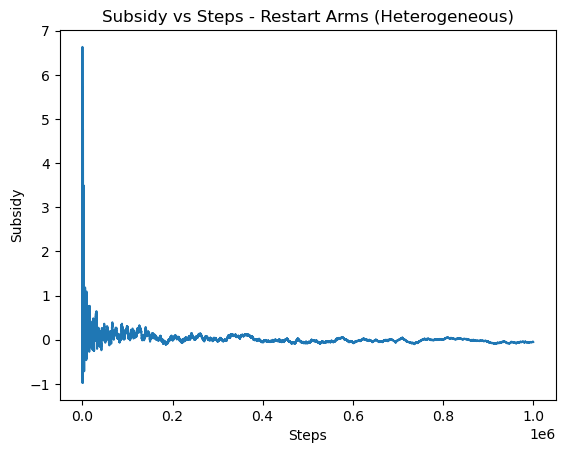

In [34]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps - Restart Arms (Heterogeneous)')

In [16]:
subsidy

-0.05254958399291927

In [17]:
df=pd.DataFrame(rewards)


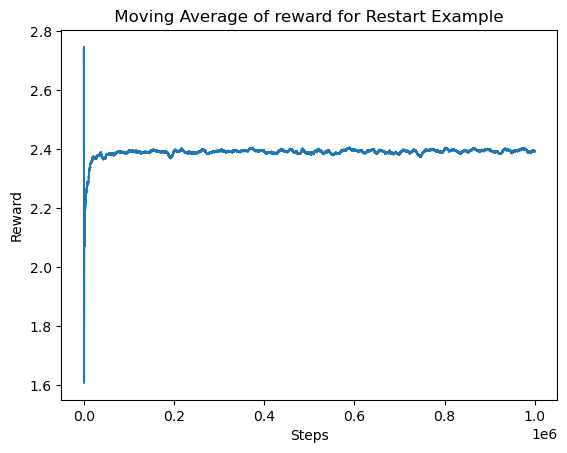

In [18]:
plt.plot(df[0].rolling(10000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Restart Example ')
plt.savefig('Moving Average of reward for Restart Example.png')

Text(0.5, 1.0, ' Moving Average of number of arms activated - Restart Arms (Heterogeneous)')

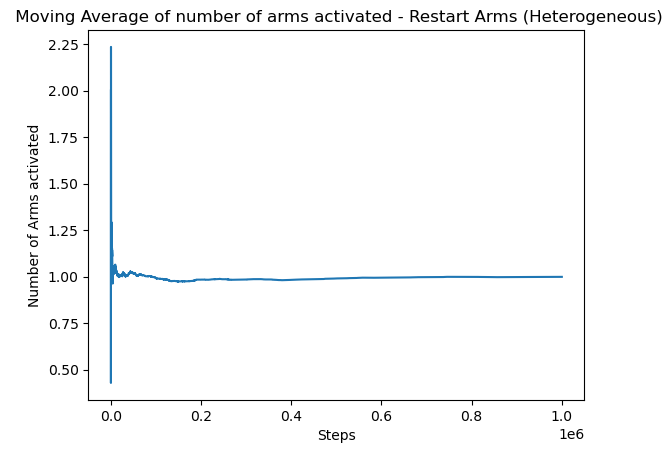

In [33]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(1000000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated - Restart Arms (Heterogeneous)')
# plt.savefig('Moving Average of number of arms activated for Restart Example.png')

In [20]:
# whittle_indexes[8]

In [21]:
# whittle_indexes_over_time[2]

In [22]:
#plotting evolution of whittle indexes of arm 9 states

# state1=[whittle_indexes_over_time[i][8][0] for i in range(500000)]
# state2=[whittle_indexes_over_time[i][8][1] for i in range(500000)]
# state3=[whittle_indexes_over_time[i][8][2] for i in range(500000)]
# state4=[whittle_indexes_over_time[i][8][3] for i in range(500000)]
# state5=[whittle_indexes_over_time[i][8][4] for i in range(500000)]
# plt.plot(state1,color='r',label='state 1')
# plt.plot(state2,color='g',label='state 2')
# plt.plot(state3,color='b',label='state 3')
# plt.plot(state4,color='y',label='state 4')
# plt.plot(state5,color='purple',label='state 5')
# plt.legend()
# plt.ylabel('Whittle Index')
# plt.xlabel('steps')
# plt.ylim([-1,0])


In [23]:
# #plotting evolution of whittle indexes of arm 8 states
# t=1000000
# for j in range(N):
#     state1=[whittle_indexes_over_time[i][j][0] for i in range(t)]
#     state2=[whittle_indexes_over_time[i][j][1] for i in range(t)]
#     state3=[whittle_indexes_over_time[i][j][2] for i in range(t)]
#     state4=[whittle_indexes_over_time[i][j][3] for i in range(t)]
#     state5=[whittle_indexes_over_time[i][j][4] for i in range(t)]
#     plt.figure()
#     plt.plot(state1,color='r',label='state 1')
#     plt.plot(state2,color='g',label='state 2')
#     plt.plot(state3,color='b',label='state 3')
#     plt.plot(state4,color='y',label='state 4')
#     plt.plot(state5,color='purple',label='state 5')
#     plt.legend()
#     plt.ylabel('Whittle Index')
#     plt.xlabel('steps')
#     plt.ylim([-1,1])
#     plt.show()


In [24]:
current_state

[1, 0, 0, 1, 1]

In [25]:
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
for i in range(1,100001):
  reward_sum_alt_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q_values[index][current_state[index]][1]-Q_values[index][current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix((index+5)/10.0),P_1_matrix,reward_matrix((index+5)/10.0))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix((index+5)/10.0),P_1_matrix,reward_matrix((index+5)/10.0))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)

In [26]:
Q_values[0]

[[0.6365145108375505, 0.29682391069326436],
 [0.3576115303947091, 0.29381502245294044],
 [0.18039725829407144, 0.30433721485917326],
 [0.1663852985467973, 0.2938388080440863],
 [0.29345008119372623, 0.32065406802156166]]

In [27]:
whittle_indexes=[[-0.48892622121978974,
 -0.13002667414860714,
 0.07845132139051907,
 0.2468133262054437,
 0.7567025001124185],[-0.5999999995442491,
 -0.21220642312820912,
 0.06596513677544474,
 0.2448317271001214,
 0.3871150075437588],[-0.6999999971135857,
 -0.33791092169106024,
 -0.01988865746870765,
 0.2324268820604551,
 0.3637076056530988],[-0.7999999939285084,
 -0.5086695852261819,
 -0.198400950853426,
 0.0943789383042964,
 0.33831136151900687],[-0.8999999857150341,
 -0.7280899048807282,
 -0.5063880276153208,
 -0.26469859446651006,
 -0.02349460739783953]]

In [28]:
reward_sums_whittle_index=[]
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
for i in range(1,100001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=whittle_indexes[index][current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix((index+5)/10.0),P_1_matrix,reward_matrix((index+5)/10.0))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix((index+5)/10.0),P_1_matrix,reward_matrix((index+5)/10.0))
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward - Restart Arms (Heterogeneous) ')

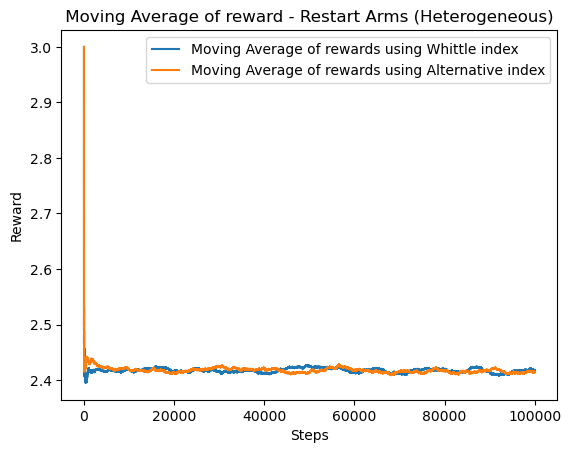

In [29]:
df_rewards=pd.DataFrame()
df_rewards['reward_whittle']=reward_sums_whittle_index
df_rewards['reward_alternate']=reward_sums_alt_index

plt.plot(df_rewards['reward_whittle'][:100000].rolling(5000,min_periods=1).mean(),label='Moving Average of rewards using Whittle index')
plt.plot(df_rewards['reward_alternate'][:100000].rolling(5000,min_periods=1).mean(),label='Moving Average of rewards using Alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward - Restart Arms (Heterogeneous) ')

Text(0.5, 1.0, ' Moving Average of reward - Restart Arms (Heterogeneous) ')

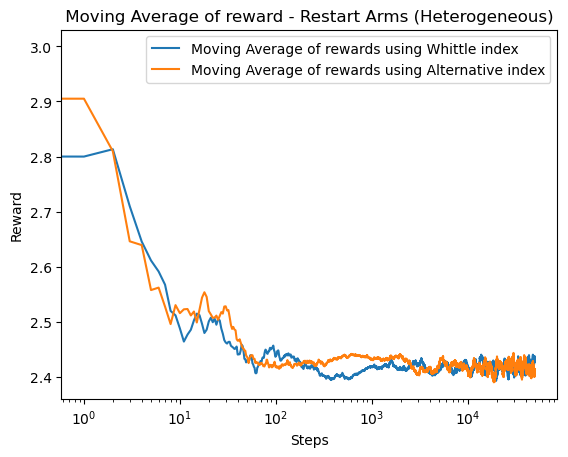

In [31]:
x=[ i for i in range(50000)]
plt.semilogx(x,df_rewards['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using Whittle index')
plt.semilogx(x,df_rewards['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using Alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward - Restart Arms (Heterogeneous) ')